In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from statsmodels.multivariate.manova import MANOVA
from statsmodels.multivariate.pca import PCA
from scipy.stats import norm

In [28]:
class TypeException(Exception):
    '''Categorical data cannot be input to a histogram'''
    

# An Exploratory Analysis on US Election Results for 1992 in Preparation for Prediction Tasks

For the 5th and final project I decided to use a dataset that I compiled for a class project for my master's in statistics. However, due to the time-limits associated with the length of the presentation I did not get to present much of the exploratory analysis I conducted. In this project I will use EDA to explore the structure of the data.

These data are from two sources:
+ [U.S. County Vote for Clinton 1992 & Demographics ](http://users.stat.ufl.edu/~winner/datasets.html)
+ [Wikipedia](https://en.wikipedia.org/wiki/1992_United_States_presidential_election)

The demographic variables for the year of 1992 are from the [first link](http://users.stat.ufl.edu/~winner/datasets.html) and the election results are web-scrapred, using the R-language, from the [second link](https://en.wikipedia.org/wiki/1992_United_States_presidential_election). R was the mandatory language used for the Multivariate Statistical Analysis class that I completed the original project for, therefore R was used to webscrape the data. The "full_dataset.csv" is the result of combining the data from the [first link](http://users.stat.ufl.edu/~winner/datasets.html) and [second link](https://en.wikipedia.org/wiki/1992_United_States_presidential_election) and then hours of cleaning.

The goal for my class project was to be able to classify whether a U.S county was won by Democratic candidate Bill Clinton or not during the presidential election of the year 1992 using statistical models or machine-learning. In addition, in the class project I used a MANOVA to determine if there was a difference in the means of each of the demographic variables and conducted a small PCA to possibly use as the input of the models just described. Due to time constraints, I conducted the PCA but never used them as the input to the models.

The details of the variables can be found in the powerpoint accompanying this report and the code cells below using the info() and head() methods.

The purpose of this exploratory analysis is as follows:
+ Do states that Clinton/Bush won have vote percentages at or above 50%?
+ What is the vote percentage breakdown for each of the regions of the U.S?
+ Determine the structure of the data
  - Does response class imbalance exist?
  - What kind of class separation exists between the counties that Clinton won vs. lost?
  - Is there correlation present in this dataset?
+ Do the assumptions of the MANOVA hold?
  - Between sample independence
  - Normality
+ If the MANOVA passes can we visualize these differences?
  - boxplots? These show medians, not means (a similar, but not totally fair comparison).
+ Principal components
  - How many components to retain using visual aids?

In [13]:
election = pd.read_csv('full_dataset.csv')
election_cp = election.copy()

In [111]:
election_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2413 entries, 0 to 2412
Data columns (total 17 columns):
county_name                 2413 non-null object
percent_for_clinton         2413 non-null float64
median_age                  2413 non-null float64
mean_savings                2413 non-null int64
per_capita_income           2413 non-null int64
percent_in_poverty          2413 non-null float64
percent_veterans            2413 non-null float64
percent_female              2413 non-null float64
population_density          2413 non-null float64
percent_in_nursing_homes    2413 non-null float64
crime_index_PC              2413 non-null int64
state                       2413 non-null object
color                       2413 non-null object
region                      2413 non-null object
bush_perc                   2413 non-null float64
clinton_perc                2413 non-null float64
clinton_win                 2413 non-null bool
dtypes: bool(1), float64(9), int64(3), object(4)
memory 

In [14]:
election_cp.head(5)

county_name  percent_for_clinton  median_age  mean_savings  \
0     Autauga                30.92        31.7         57623   
1     Baldwin                26.24        35.5         84935   
2     Barbour                46.36        32.8         83656   
3      Blount                32.92        34.5         61249   
4     Bullock                67.67        31.7         75725   

   per_capita_income  percent_in_poverty  percent_veterans  percent_female  \
0              15768                15.2             10.74           51.41   
1              16954                13.6              9.73           51.34   
2              15532                25.0              8.82           53.03   
3              14820                15.0              9.67           51.15   
4              11120                33.0              7.08           50.76   

   population_density  percent_in_nursing_homes  crime_index_PC state color  \
0                60.4                      2.36             457    AL  Bush   
1                66.5                      5.40             282    AL  Bush   
2                28.8                      7.02              47    AL  Bush   
3                62.4                      2.36             185    AL  Bush   
4                17.6                      2.91             141    AL  Bush   

      region  bush_perc  clinton_perc  clinton_win  
0  Southeast      55.92         30.92        False  
1  Southeast      56.52         26.24        False  
2  Southeast      42.90         46.36         True  
3  Southeast      53.81         32.92        False  
4  Southeast      26.02         67.67         True

In [163]:
election_cp = election_cp.drop(columns=['percent_for_clinton', 'bush_perc'])

In [164]:
election_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2413 entries, 0 to 2412
Data columns (total 15 columns):
county_name                 2413 non-null object
median_age                  2413 non-null float64
mean_savings                2413 non-null int64
per_capita_income           2413 non-null int64
percent_in_poverty          2413 non-null float64
percent_veterans            2413 non-null float64
percent_female              2413 non-null float64
population_density          2413 non-null float64
percent_in_nursing_homes    2413 non-null float64
crime_index_PC              2413 non-null int64
state                       2413 non-null object
color                       2413 non-null object
region                      2413 non-null object
clinton_perc                2413 non-null float64
clinton_win                 2413 non-null bool
dtypes: bool(1), float64(7), int64(3), object(4)
memory usage: 266.4+ KB


In [94]:
print(election_cp['percent_in_poverty'].dtype)

float64


In [225]:
"""
This function plots the histograms of associated with the variables in Pandas.Series

@param *args - One or multiple names (as a string) of the variables to be plotted
@param data - the dataset (Pandas.DataFrame) that the variables are located in
"""
def histograms(*args, data):
    n_args = len(args)
    counters = [i for i in range(n_args)]
    figs, axs = plt.subplots(nrows=1, ncols=n_args, figsize=[15, 10]);
    for counter in counters:
        if n_args > 1:
            if (data[args[counter]].dtype == 'float64' or data[args[counter]].dtype == 'int64'):
                axs[counter].hist(data[args[counter]]); 
                axs[counter].set_ylabel('Frequency');
                axs[counter].set_xlabel(args[counter].replace("_", " ").title());
                axs[counter].set_title(('Histogram of {}').format(args[counter].replace('_', ' ').title()))
            else:
                raise TypeException('Underlying data type is not numerical.')
        else:
            if (data[args[counter]].dtype == 'float64' or data[args[counter]].dtype == 'int64'):
                axs.hist(data[args[counter]]);
                axs.set_xlabel(args[counter].replace("_", " ").title());
                axs.set_ylabel('Frequency');
                axs.set_title(("QQ-Plot for {}").format(args[counter].replace("_", " ").title()))
            else:
                raise TypeException('Underlying data type is not numerical.')
    filename = str(None)
    for arg in args:
        filename += arg + " "
    filename = filename.strip().replace(" ", "_")
    plt.savefig('QQ-plot_{}.png'.format(filename), format='png')

In [325]:
"""
This function plots the histograms of associated with the log transformation of the variables in Pandas.Series

@param *args - One or multiple names (as a string) of the variables to be plotted
@param data - the dataset (Pandas.DataFrame) that the variables are located in
"""
def log_histograms(*args, data):
    n_args = len(args)
    counters = [i for i in range(n_args)]
    figs, axs = plt.subplots(nrows=1, ncols=n_args, figsize=[15, 10]);
    for counter in counters:
        if n_args > 1:
            if (data[args[counter]].dtype == 'float64' or data[args[counter]].dtype == 'int64'):
                axs[counter].hist(data[args[counter]].apply(lambda x: np.log(x))); 
                axs[counter].set_ylabel('Frequency');
                axs[counter].set_xlabel(args[counter].replace("_", " ").title());
                axs[counter].set_title(('Histogram of {}').format(args[counter].replace('_', ' ').title()))
            else:
                raise TypeException('Underlying data type is not numerical.')
        else:
            if (data[args[counter]].dtype == 'float64' or data[args[counter]].dtype == 'int64'):
                axs.hist(data[args[counter]].apply(lambda x: np.log(x)), bins=30);
                axs.set_xlabel(("log({})").format(args[counter].replace("_", " ").title()))
                axs.set_ylabel('Frequency');
                axs.set_title(("Histogram for log({})").format(args[counter].replace("_", " ").title()))
            else:
                raise TypeException('Underlying data type is not numerical.')
    filename = str(None)
    for arg in args:
        filename += arg + " "
    filename = filename.strip().replace(" ", "_")
    plt.savefig('log_histogram_{}.png'.format(filename), format='png')

In [299]:
"""
this function plots the QQ-plots of the subpopulations of a variable(s) in a pandas dataset.
Make note that the categorical variable provided must be a boolean - Even though it would have been simple to
generalize, I decided not to do so since I knew the only categorical variable I would be using was a two-level,
nominal, boolean valued categorical variable.

@parameter args One or multiple names (as a string) of the variables to be plotted.
@parameter data - the dataset (Pandas.DataFrame) that the variables are located in.
@parameter catvar - the categorical variable/factor that represents the subpopulated data.
"""
def qqplots(*args, data, catvar):
    n_args = len(args)
    cat_levels = list(data[catvar].unique())
    count_list = [i for i in range(1, n_args+ 1)]
    colors = ['red', 'blue']
    figs, axs = plt.subplots(nrows=1, ncols=n_args, figsize=[20,10]);
    for i in count_list:
        for level in cat_levels:
            data_sub = data[data[catvar] == level]
            n_points = data_sub.shape[0]
            samp_mean = data_sub[args[i - 1]].mean()
            samp_sd = data_sub[args[i-1]].std()
            qs = (np.arange(n_points) - 0.5) / n_points
            expected_vals = norm.ppf(qs, samp_mean, samp_sd)
            min_sample = data_sub[args[i - 1]].quantile(q=0.001)
            max_sample = data_sub[args[i - 1]].quantile(q=0.999)
            if n_args > 1:
                axs[i - 1].scatter(expected_vals, data_sub[args[i-1]].sort_values(), c=colors[int(level)]);
                axs[i - 1].legend(['y=x', 'Bush', 'Clinton'])
                axs[i - 1].plot([min_sample, max_sample], [min_sample, max_sample], '--', color='black');
                axs[i - 1].set_ylabel('Sample Quantiles');
                axs[i - 1].set_xlabel('Theoretical Quantiles');
                axs[i - 1].set_title(("QQ-Plot for {}").format(args[i-1].replace("_", " ").title()))
            else:
                axs.scatter(expected_vals, data_sub[args[i-1]].sort_values(), c=colors[int(level)] );
                axs.legend(['y=x', 'Bush', 'Clinton'])
                axs.plot([min_sample, max_sample], [min_sample, max_sample], '--', color='black');
                axs.set_ylabel('Sample Quantiles');
                axs.set_xlabel('Theoretical Quantiles');
                axs.set_title(("QQ-Plot for {}").format(args[i-1].replace("_", " ").title()))
    filename = str(None)
    for arg in args:
        filename += arg + " "
    filename = filename.strip().replace(" ", "_")
    plt.savefig('QQ-plot_{}.png'.format(filename), format='png')

In [320]:
election_cp['sqrt_crime_index'] = np.sqrt(election_cp['crime_index_PC'])
election_cp['log_mean_savings'] = np.log(election_cp['mean_savings'])
election_cp['log_per_capita_income'] = np.log(election_cp['per_capita_income'])
election_cp['log_percent_in_poverty'] = np.log(election_cp['percent_in_poverty'])
election_cp['log_nursing_homes'] = np.log(election_cp['percent_in_nursing_homes'])
election_cp['log_percent_veterans'] = np.log(election_cp['percent_veterans'])
election_cp['log_population_density'] = np.log(election_cp['population_density'])
election_cp['log_percent_female'] = np.log(election_cp['percent_female'])

### Median age and Mean Savings - Histograms
Median age seems appears to have a symmetric distribution (possibly normal) while mean savings has a right skewed distribution.

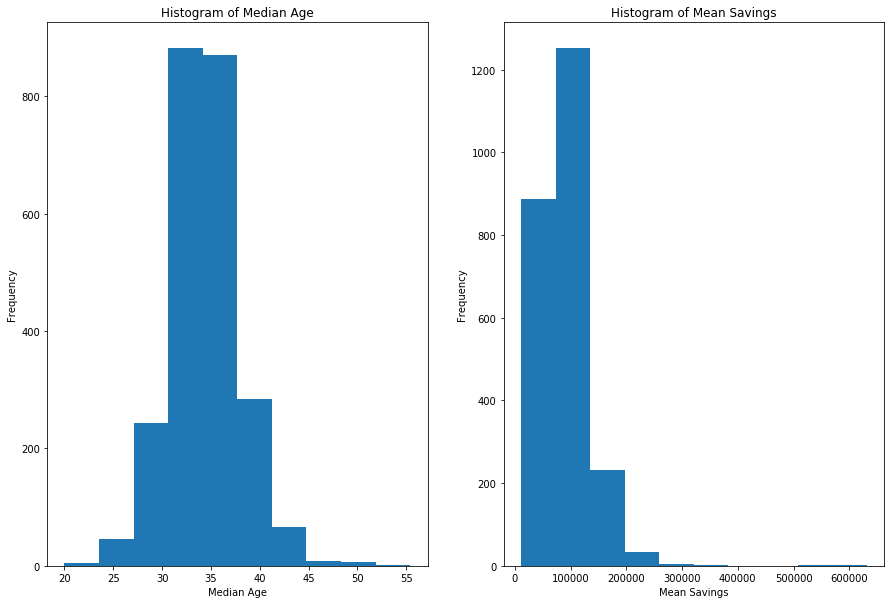

In [266]:
histograms('median_age', 'mean_savings', data=election_cp)

### Per Capita Income and Percent In Poverty - Histograms
Both of these distributions seem to have a long right tail - possibly log transformaton will make them normally distributed.

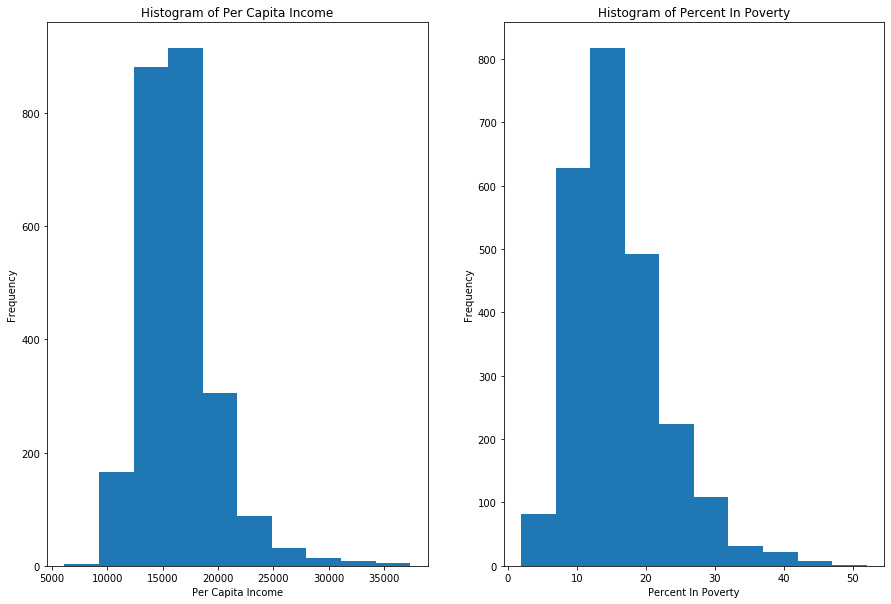

In [267]:
histograms('per_capita_income', 'percent_in_poverty', data=election_cp)

### Percent Veterans and Percent Female - Histograms
Percent veterans seems to have a symmetric distribution while percent female seems to have a left skewed distribution.

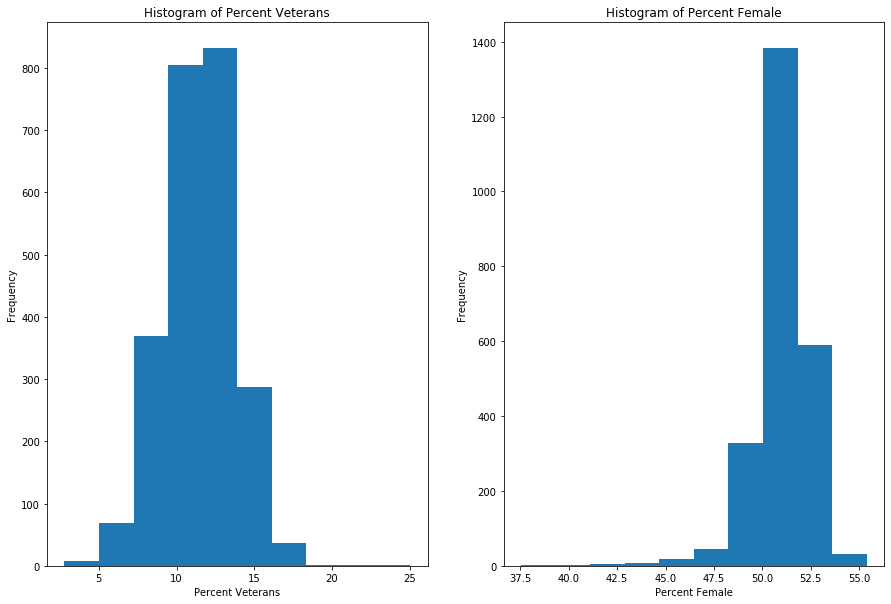

In [268]:
histograms('percent_veterans', 'percent_female', data=election_cp)

### Population density and Pecent in Nursing Homes - Histograms
Population density has a heavily right-skewed distribution and Percent in Nursing homes also has a long right tail.

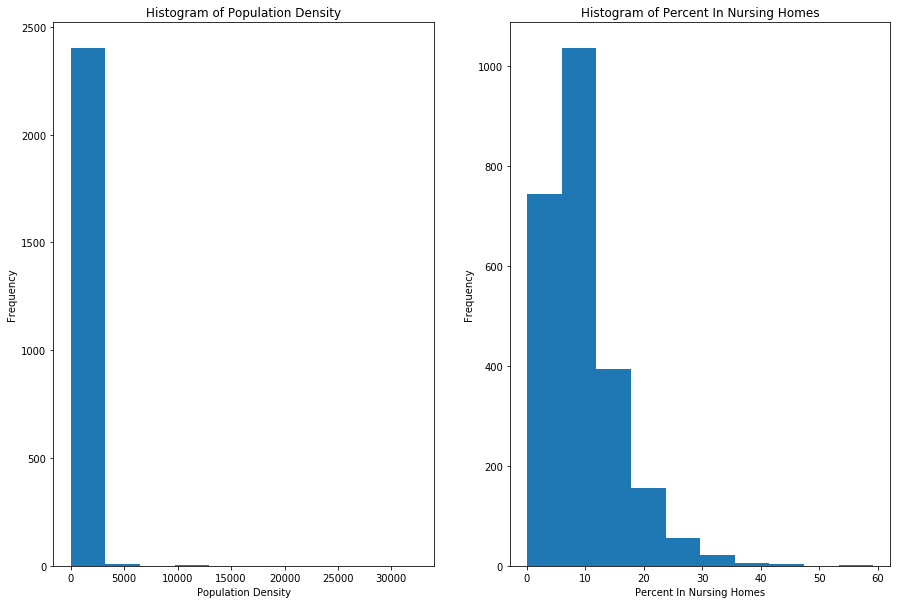

In [269]:
histograms('population_density', 'percent_in_nursing_homes', data=election_cp)

### Crime Index Per Capita and Clinton Perc - Histograms
Crime Index Per Capita has a right-skewed distribution while Clinton Perc seems to have a symmetric distribution

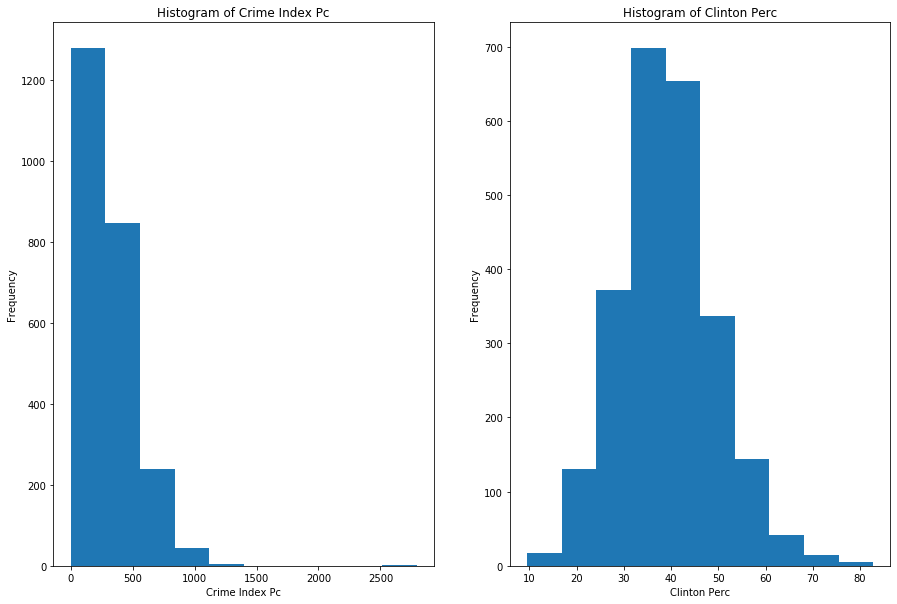

In [270]:
histograms('crime_index_PC', 'clinton_perc', data=election_cp)

### Transformed Crime Index Per Capita - Histogram and QQ-plots
After taking the square root transformation of Crime Index Per Capita we see that the transform is not approximately normally distributed with an outlier at around 50 (transformed value). In addition we see that the subpopulations (a Clinton loss or victory in a county) are also approximately normally distributed.

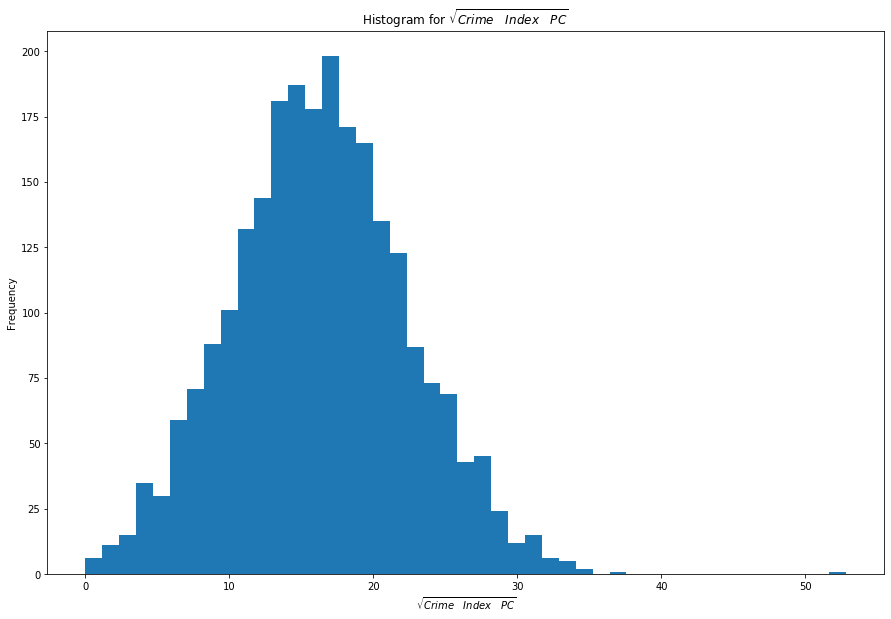

In [194]:
plt.figure(figsize=[15, 10]);
plt.hist(election_cp['crime_index_PC'].apply(lambda x: np.sqrt(x)), bins=45);
plt.xlabel(r'$\sqrt{Crime \quad Index \quad PC}$');
plt.ylabel('Frequency');
plt.title('Histogram for $\sqrt{Crime \quad Index \quad PC}$');

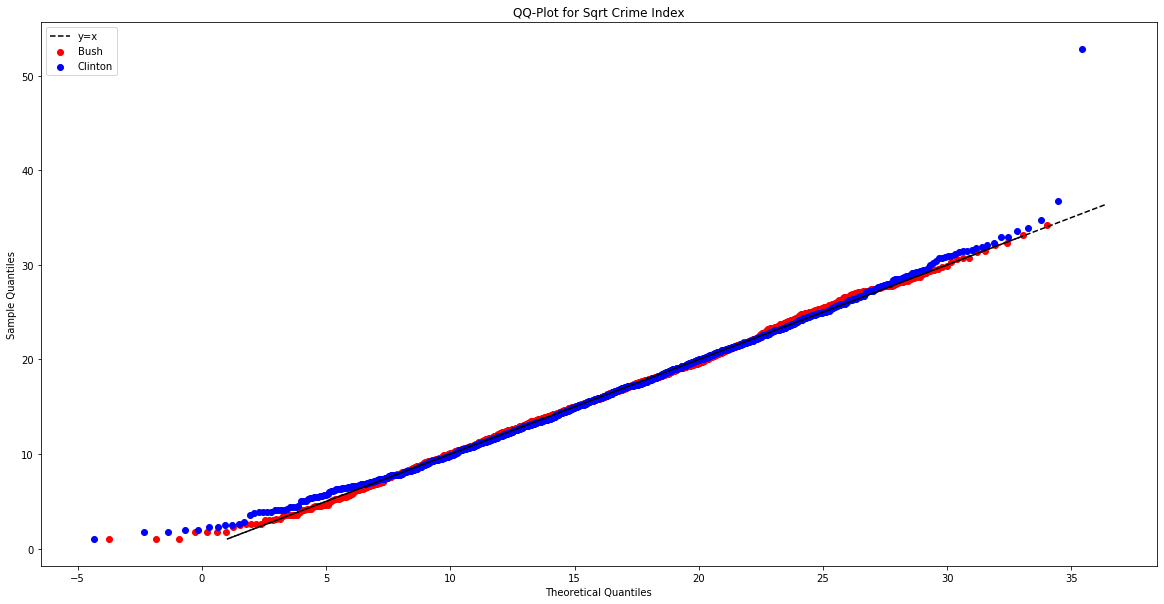

In [300]:
qqplots('sqrt_crime_index', data=election_cp, catvar='clinton_win')

### Transformed Mean Savings - Histogram and QQ-plots
As we can see, the log transform of Mean Savings now has an approximately normal distribution. Also from the QQ-plots we see that the subpopulations (a Clinton loss or victory) are also approximately normally distributed.

In [196]:
np.log(election_cp['mean_savings'].describe())

count     7.788626
mean     11.411186
std      10.613110
min       9.270306
25%      11.057834
50%      11.334779
75%      11.591977
max      13.355907
Name: mean_savings, dtype: float64

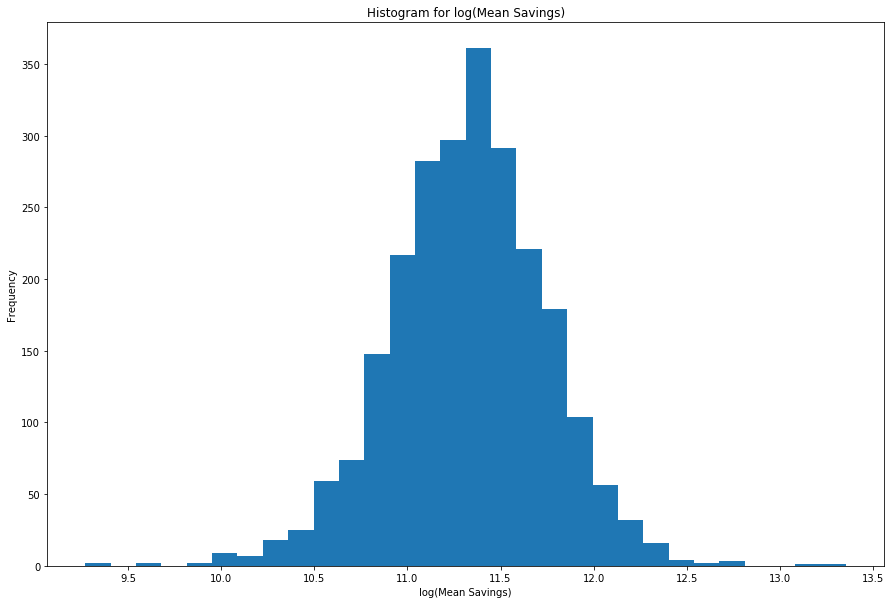

In [259]:
log_histograms('mean_savings', data=election_cp)

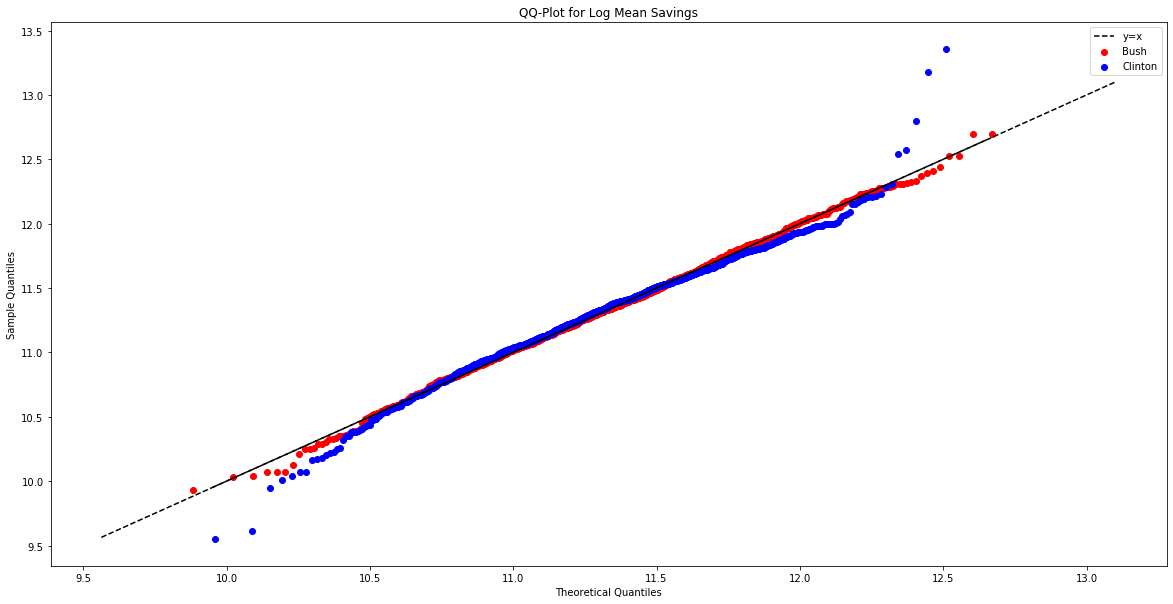

In [301]:
qqplots('log_mean_savings', data=election_cp, catvar='clinton_win')

### Transformed Per Capita Income - Histogram and QQ-plots
The log transformation of Per Capita Income is now approximately normally disributed and the subpopulations of a Clinton loss or victory are also approximately normally distributed.

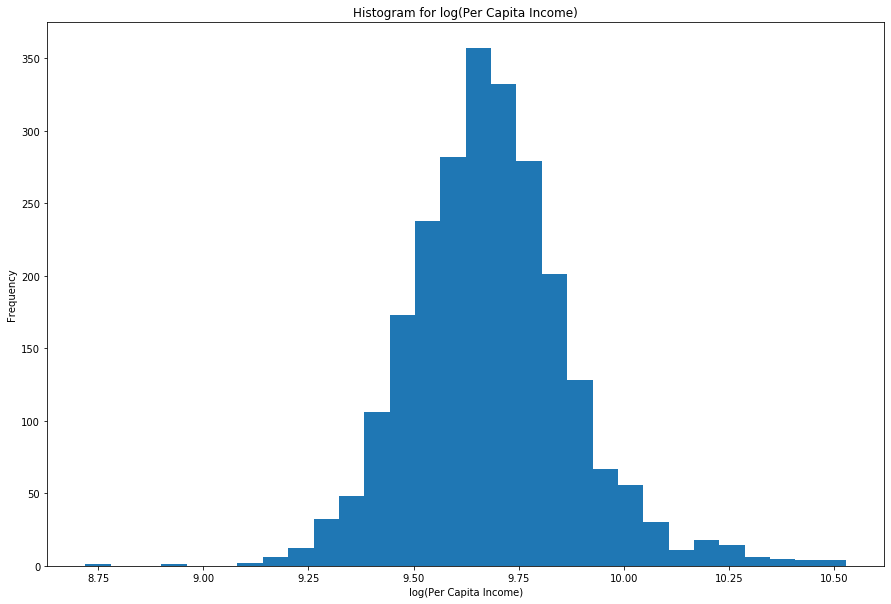

In [260]:
log_histograms('per_capita_income', data=election_cp)

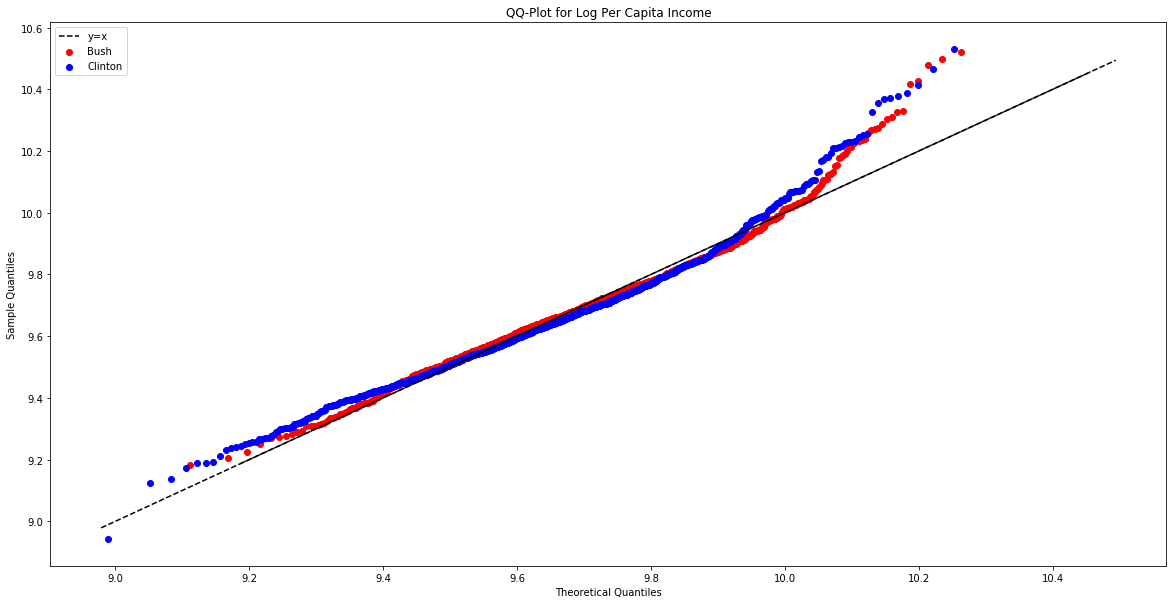

In [302]:
qqplots('log_per_capita_income', data=election_cp, catvar='clinton_win')

### Transformation Percent In Poverty - Histogram and QQ-plot
The log transformation of Percent In Poverty now seems to symmetrically and quite possibly normally distributed. In addition, the log transform of the subpopulations also seem to be normally distributed.

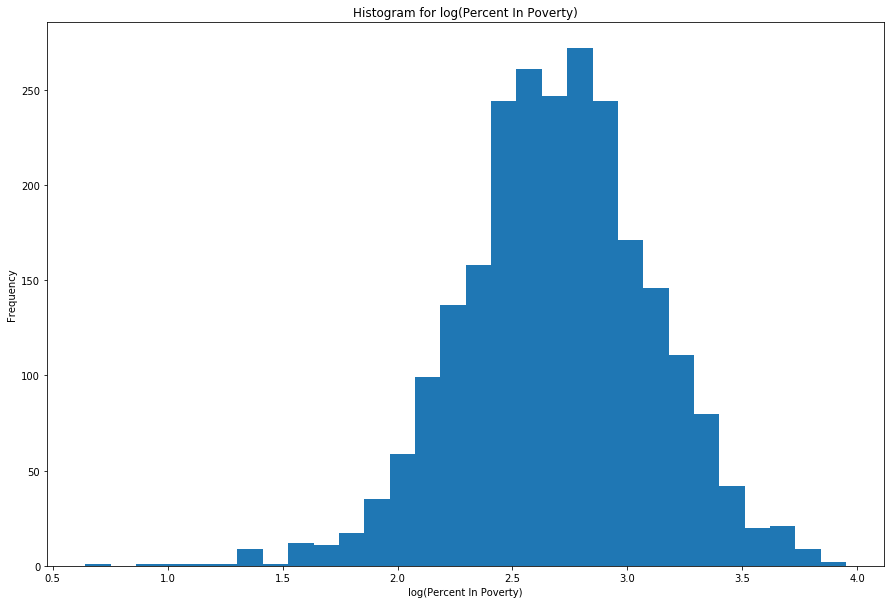

In [261]:
log_histograms('percent_in_poverty', data=election_cp)

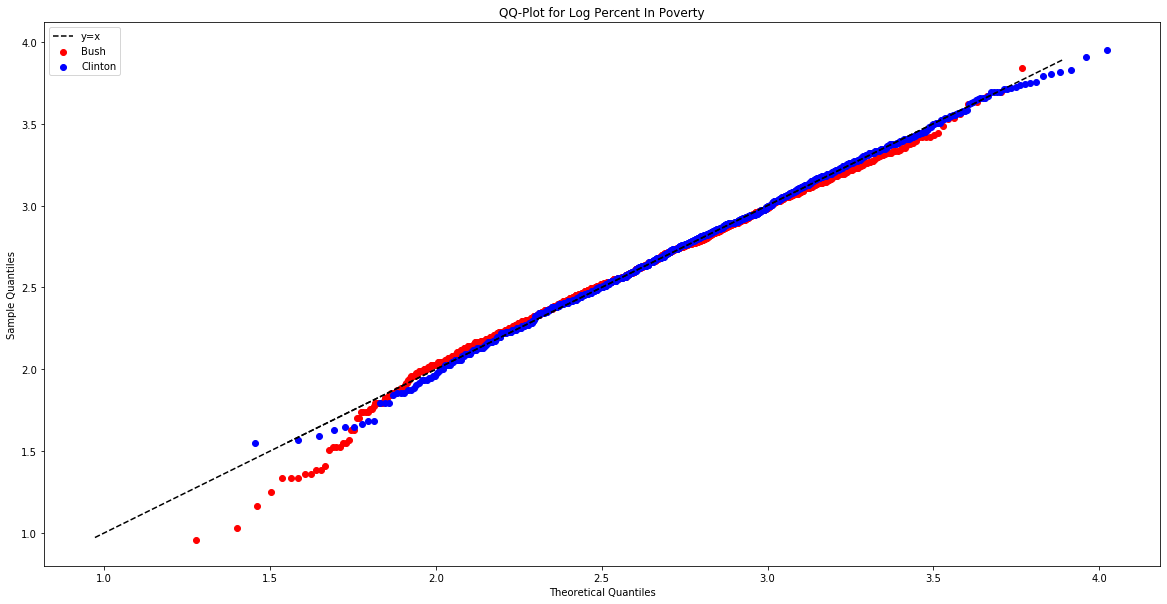

In [303]:
qqplots('log_percent_in_poverty', data=election_cp, catvar='clinton_win')

### Transformed Percent In Nursing Homes - Histogram and QQ-plots
Percent in Nursing Homes now seems to be normally distributed while the subpopulations (A Clinton loss or victory) also seem to be normally distributed.

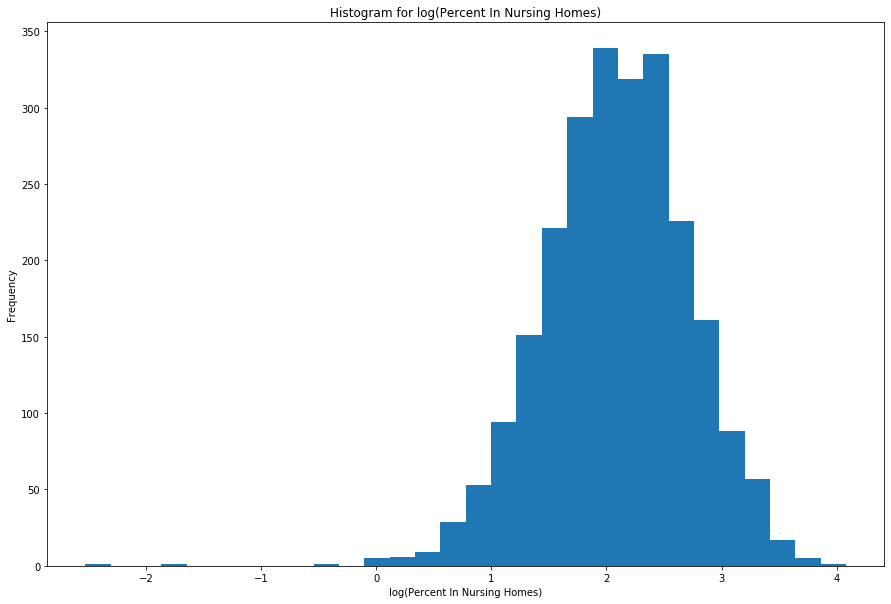

In [262]:
log_histograms('percent_in_nursing_homes', data=election_cp)

False
True


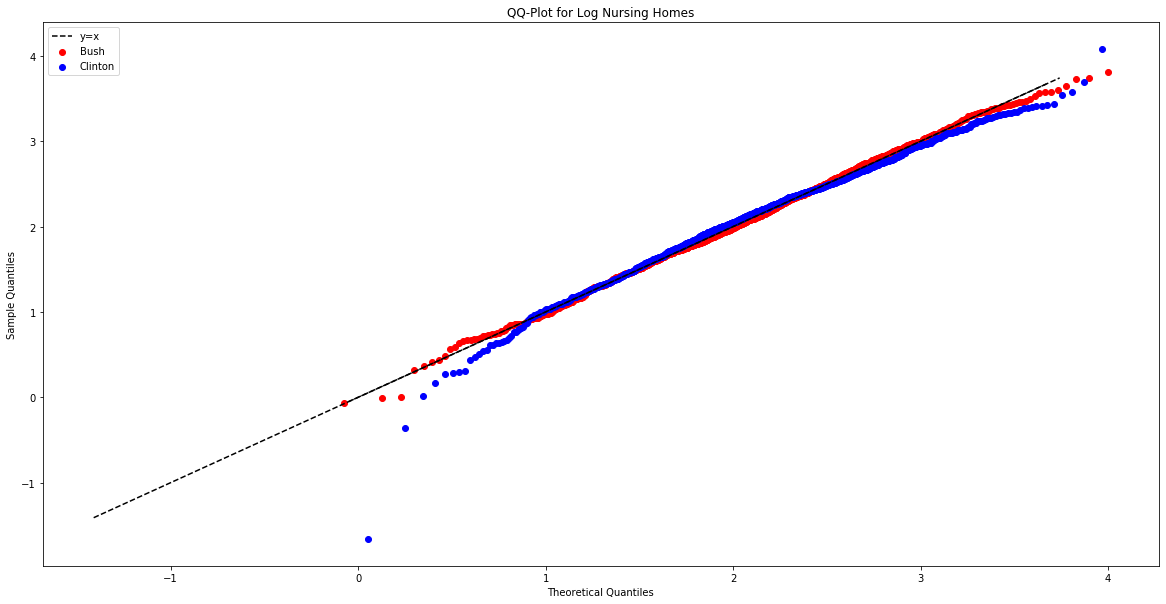

In [294]:
qqplots('log_nursing_homes', data=election_cp, catvar='clinton_win')

### Percent Veterans - Histogram and QQ-plot (A re-look)
Percent veterans seemed like it might have already been normally distributed from the histogram earlier. Therefore I present the histogram again and, in addition, I give the QQ-plot for the subpopulations which also seem to be normally distributed.

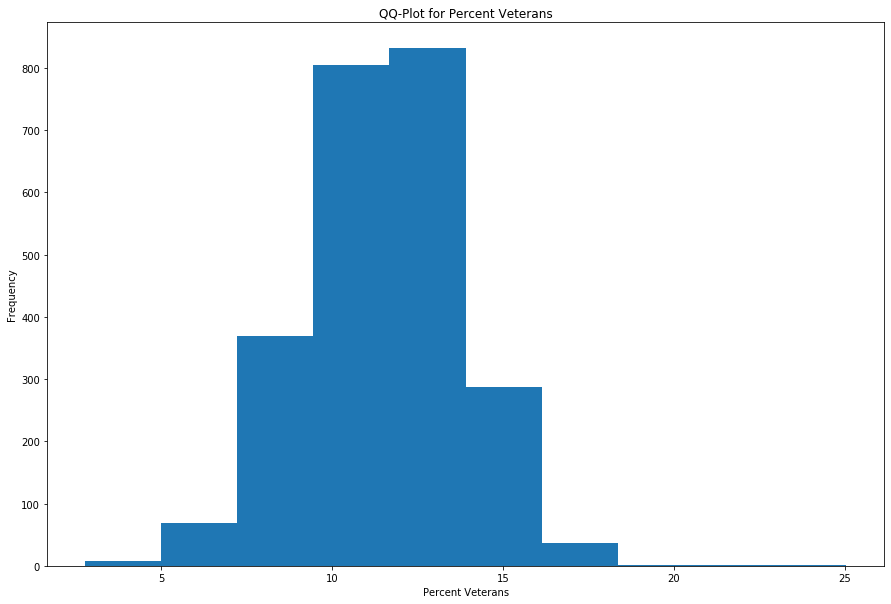

In [305]:
histograms('percent_veterans', data=election_cp)

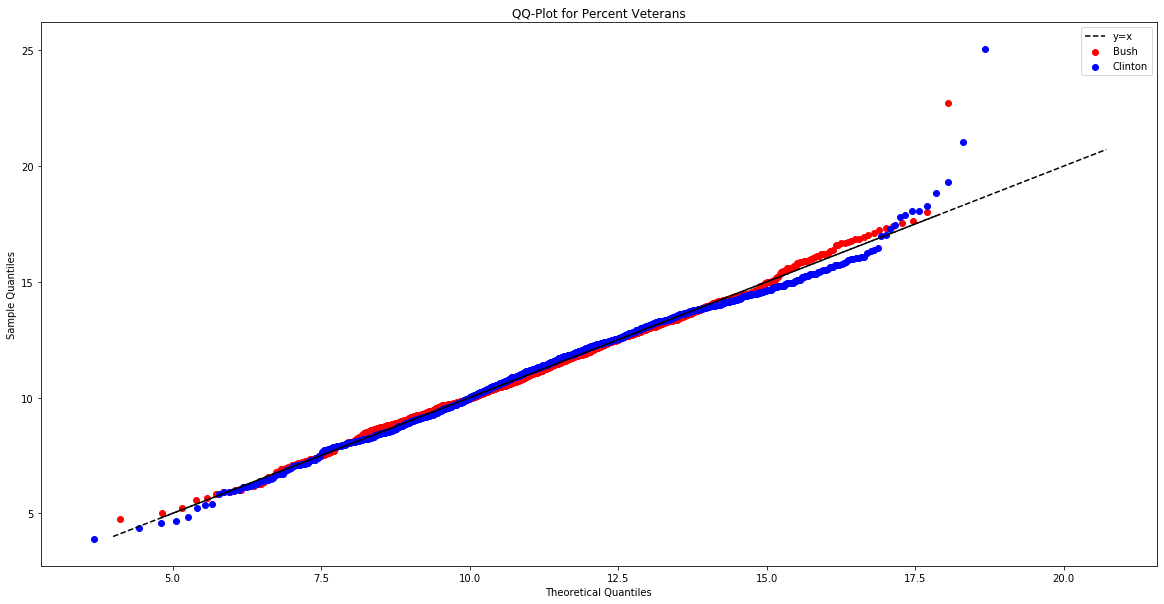

In [307]:
qqplots('percent_veterans', data=election_cp, catvar='clinton_win')

### Transformed Population Density - Histogram and QQ-plot
Population density seems like it might still have an issue with normality. As can be seen from the figure below, the distribution has a bit of a sharp-cusp instead of a nice bell-shape. However, It doesn't deviated *too far* from normality so it should be okay for any models that require normality. Lastly, since this dataset has a large sample size, the normality assumption can be relaxed anyways.

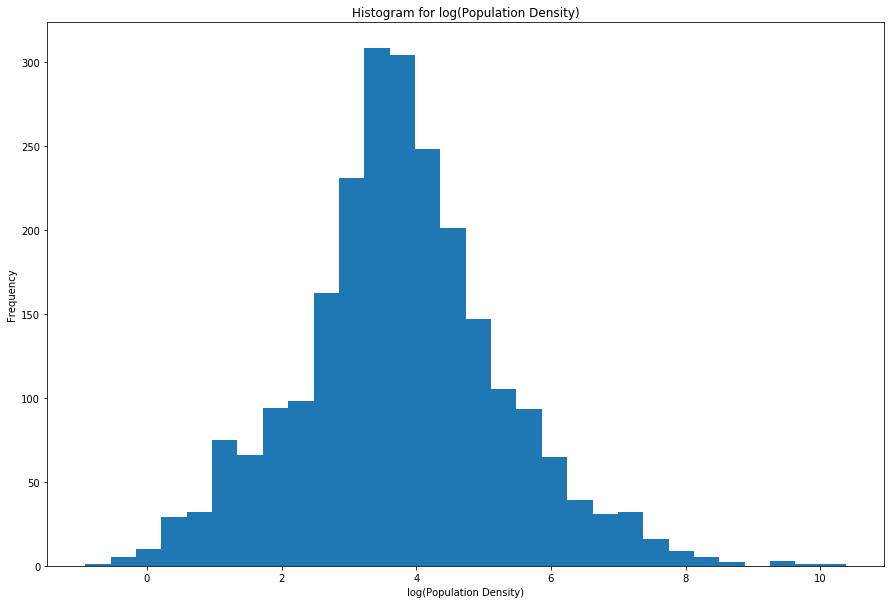

In [264]:
log_histograms('population_density', data=election_cp)

False
True


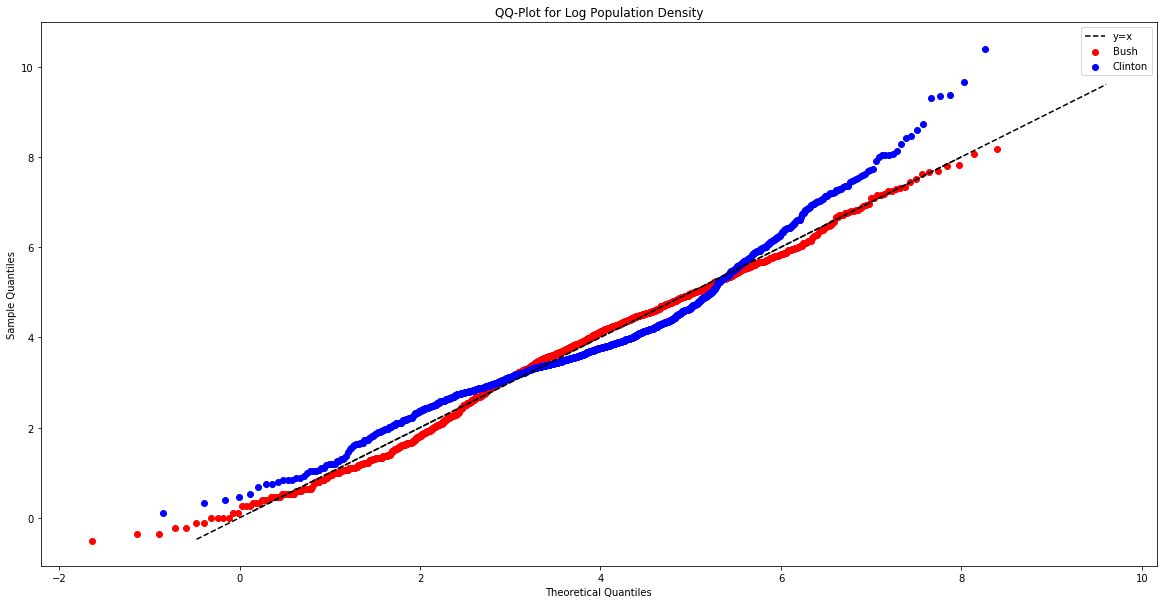

In [296]:
qqplots('log_population_density', data=election_cp, catvar='clinton_win')

### Transformed Percent Female - Histogram and QQ-plot
I tried various transformations - not just the log transformation and none of them seemed to be able to get rid of the left tail on Percent Female. The log transformation seems to do the best job of any of them though. Percent female doesn't seem to deviate *too far* from normality since it still seems to be pretty symmetric. Statistical models like ANOVA and MANOVA will likely not be affected by the left tail too much.

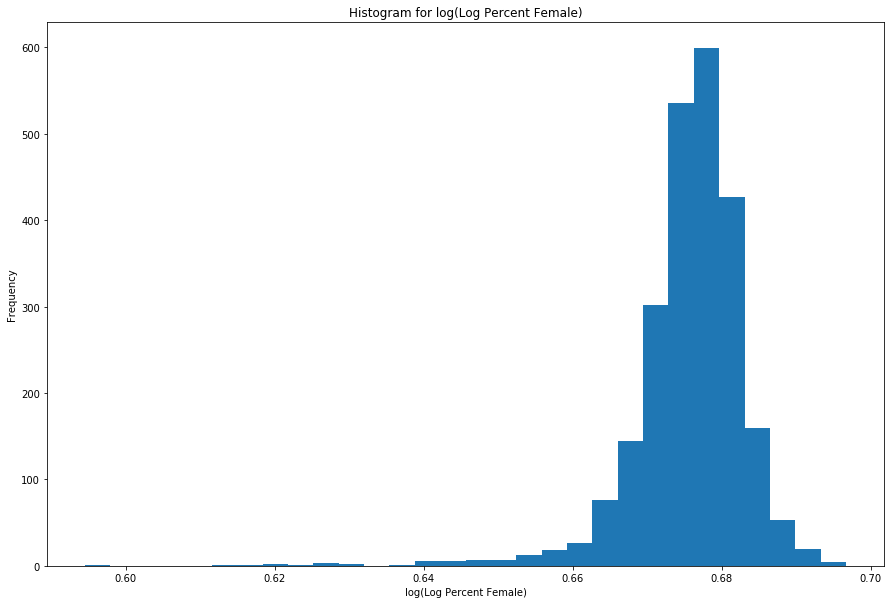

In [317]:
log_histograms('log_percent_female', data=election_cp)

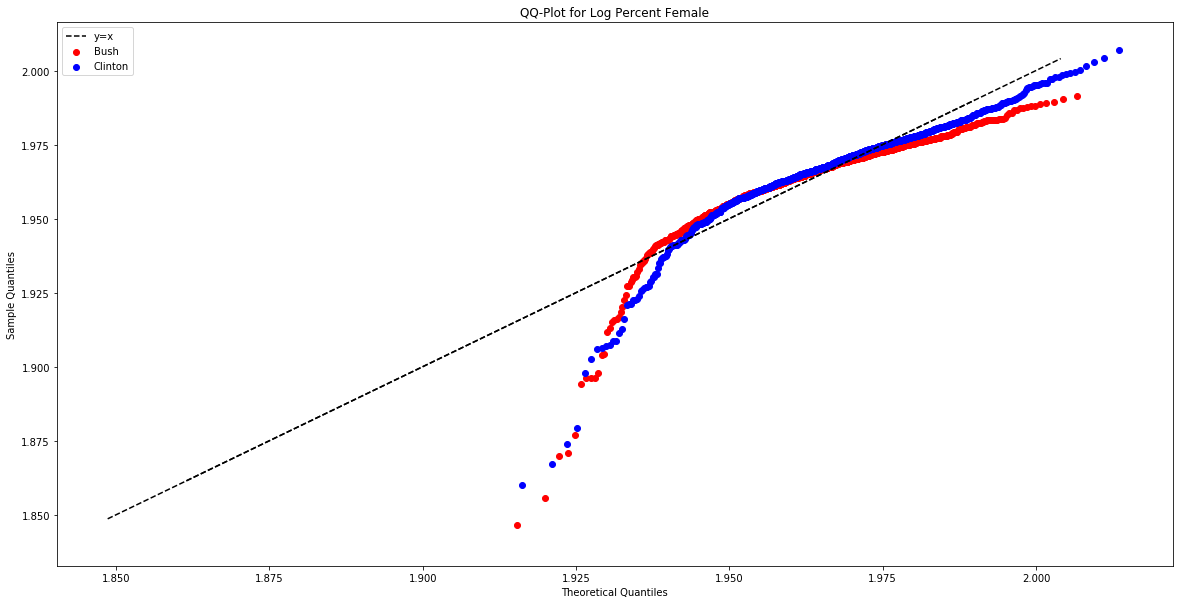

In [318]:
qqplots('log_percent_female', data=election_cp, catvar='clinton_win')

In [286]:
election_cp['sqrt_crime_index'] = np.sqrt(election_cp['crime_index_PC'])
election_cp['log_mean_savings'] = np.log(election_cp['mean_savings'])
election_cp['log_per_capita_income'] = np.log(election_cp['per_capita_income'])
election_cp['log_percent_in_poverty'] = np.log(election_cp['percent_in_poverty'])
election_cp['log_nursing_homes'] = np.log(election_cp['percent_in_nursing_homes'])
election_cp['log_percent_veterans'] = np.log(election_cp['percent_veterans'])
election_cp['log_population_density'] = np.log(election_cp['population_density'])
election_cp['log_percent_female'] = np.log(election_cp['percent_female'])

## Outliers - From each of the predictor variables
The cities that appear to be outliers from each of the predictor variables can be seen in each of the returned DataFrames from the detect_outliers() function. I don't believe in removing outliers unless they seem to be influential in an analysis. However, we are now aware of any outliers in case they seem to be a problem later.

In [274]:
def detect_outliers(cutoff, var, data, upper_tail=True):
    if upper_tail:
        temp_data = data[data[var] > cutoff]
        counties_states = temp_data[['county_name', 'state']]
    else:
        temp_data = data[data[var] < cutoff]
        counties_states = temp_data[['county_name', 'state']]   
    return counties_states

In [275]:
detect_outliers(35, 'sqrt_crime_index', election_cp)

county_name state
360       Fulton    GA
1574       Kings    NY

In [276]:
detect_outliers(13, 'log_mean_savings', election_cp)

county_name state
248   New Castle    DE
1050     Suffolk    MA

In [277]:
detect_outliers(10, 'log_mean_savings', election_cp, False)

county_name state
60        Apache    AZ
208       Elbert    CO
269     Hamilton    FL
387      Liberty    GA
430       Twiggs    GA
1917    Berkeley    SC

In [278]:
detect_outliers(9, 'log_per_capita_income', election_cp, False)

county_name state
2170    Maverick    TX
2215       Starr    TX

In [280]:
detect_outliers(1.5, 'log_percent_in_poverty', election_cp, False)

county_name state
207      Douglas    CO
356      Fayette    GA
499       DuPage    IL
523      Kendall    IL
531      McHenry    IL
604     Hamilton    IN
1027      Howard    MD
1520   Hunterdon    NJ
1524      Morris    NJ
1528    Somerset    NJ
1539  Los Alamos    NM
2366     Ozaukee    WI
2387  Washington    WI
2388    Waukesha    WI

In [282]:
detect_outliers(0, 'log_nursing_homes', election_cp, False)

county_name state
898         Hart    KY
1496    Humboldt    NV
1550        Taos    NM
1917    Berkeley    SC
2016      Sevier    TN
2312    Skamania    WA

In [283]:
detect_outliers(1.5, 'log_percent_veterans', election_cp, False)

county_name state
324       Camden    GA
2127     Hidalgo    TX
2170    Maverick    TX
2215       Starr    TX

In [284]:
detect_outliers(9, 'log_population_density', election_cp)

county_name state
178   San Francisco    CA
1050        Suffolk    MA
1519         Hudson    NJ
1574          Kings    NY
1888   Philadelphia    PA

In [287]:
detect_outliers(3.8, 'log_percent_female', election_cp, False)

county_name state
111      Lincoln    AR
146       Amador    CA
151    Del Norte    CA
160       Lassen    CA
204      Crowley    CO
220      Lincoln    CO
253     Bradford    FL
520      Johnson    IL
916         Lyon    KY
1068    Chippewa    MI
1401      Powell    MT
1501  White Pine    NV
1706    Pickaway    OH
2030    Anderson    TX
2076     Coryell    TX
2165     Madison    TX
2235      Walker    TX

## Question 1: Does response class imbalance exist?
As can be seen from the pie-chart, class imbalance in the response variable, "clinton_win", does not exist. Each class is approximately equally represented.

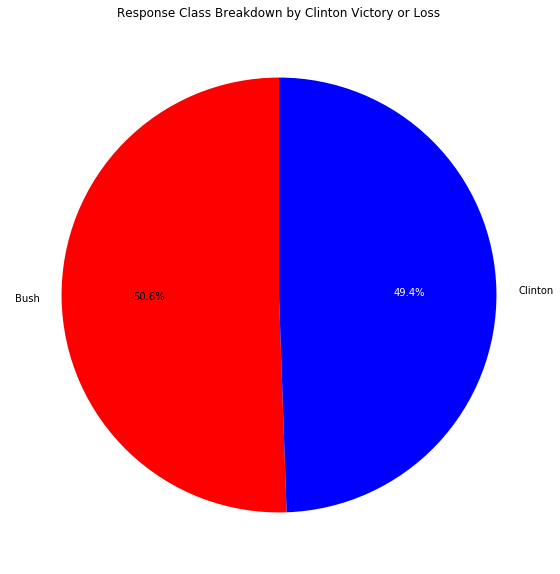

In [20]:
clinton_win_counts = election_cp['clinton_win'].value_counts().reset_index(name='counts')
counts = list(clinton_win_counts['counts'])
fig, ax = plt.subplots(figsize=[15,10]);
labels=['Bush', 'Clinton']
text_colors = ['black', 'white']
patches, texts, autotexts = ax.pie(counts, labels=labels, autopct = '%1.1f%%',startangle=90, colors=['red', 'blue']);
ax.set_title('Response Class Breakdown by Clinton Victory or Loss')
i = 0
for autotext in autotexts:
    autotext.set_color(text_colors[i])
    i += 1
plt.savefig('pie_chart.png', format='png')

In [5]:
base_color = sns.color_palette()[1]

In [6]:
state_percs = election_cp.groupby(['state', 'color']).mean()['clinton_perc']
state_percs = state_percs.reset_index(name='MeanPerc')

## Question 2: Do states that Clinton/Bush won have vote percentages at or above 50%?
As can be seen from the bar-plot, the vast majority of states that swung to the left or right for a particular candidate *did not* have vote percentages at or above 50% for their victorious candidates. This indicates a significant non-partisan candidate presence among voters for this year.

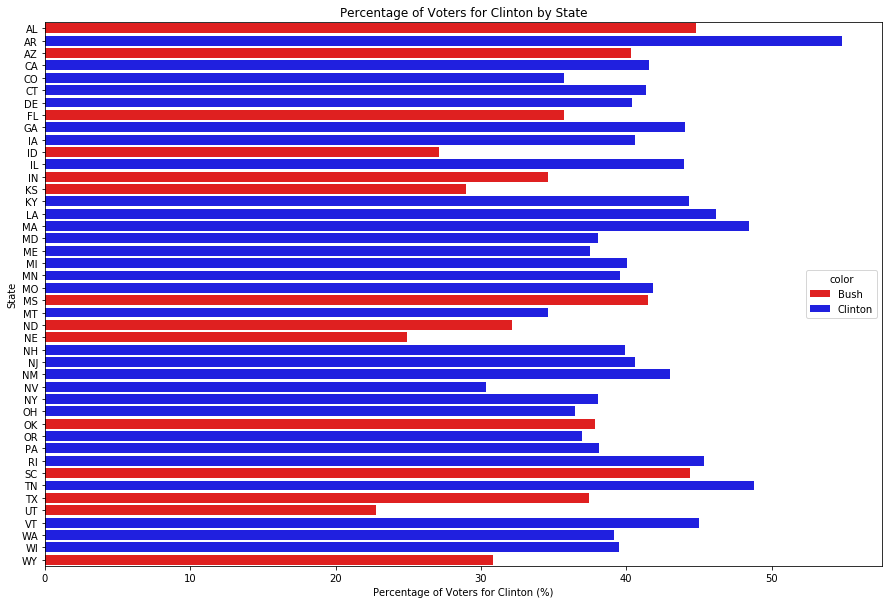

In [7]:
plt.figure(figsize=[15,10]);
sns.barplot(y='state', x='MeanPerc', hue='color', data=state_percs, dodge=False, palette=["red", "blue"]);
plt.xlabel('Percentage of Voters for Clinton (%)');
plt.ylabel('State');
plt.title('Percentage of Voters for Clinton by State');
plt.savefig('bar_vote_by_state.png', format='png')

In [8]:
region_perc = election_cp.groupby(['region']).mean()['clinton_perc']
region_perc = region_perc.reset_index(name='clinton_perc')

## Question 3: What is the vote percentage breakdown for each of the regions of the U.S?
As can be seen from the bar-plot, the southeast had the largest percentage of voters that voted for the democratic candidate, Bill Clinton, with the midwest having the smallest. This is interesting because the southeast has traditionally been a republican stronghold.

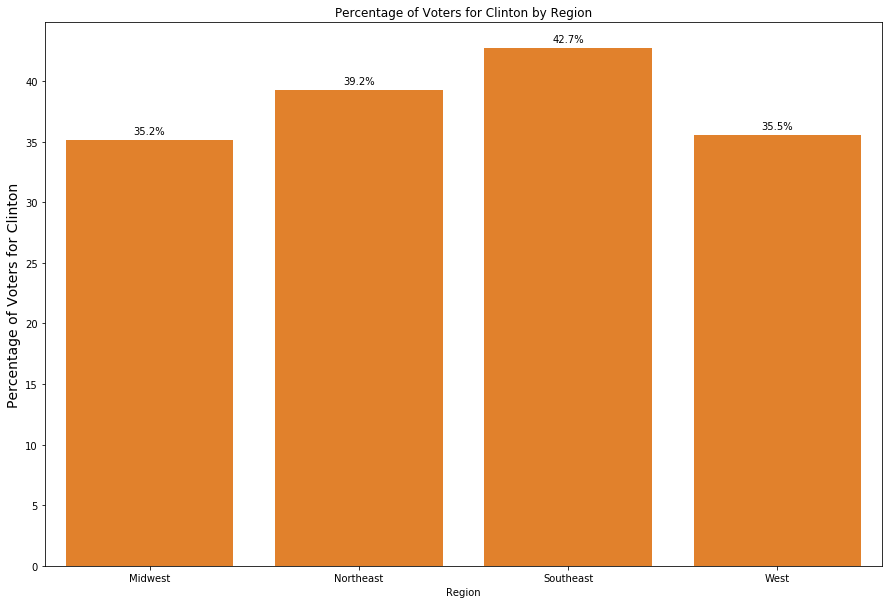

In [9]:
plt.figure(figsize=[15,10]);
s_barplot = sns.barplot(data=region_perc, x='region', y='clinton_perc', color=base_color);
for p in s_barplot.patches:
    s_barplot.annotate(s=format(p.get_height(), '.1f') + "%", 
                   xy=(p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel("Percentage of Voters for Clinton", size=14);
plt.title('Percentage of Voters for Clinton by Region');
plt.xlabel('Region');
plt.savefig('bar_voter_by_region.png', format='png')

In [10]:
election_cp.groupby(['clinton_win']).head()

county_name  percent_for_clinton  median_age  mean_savings  \
0     Autauga                30.92        31.7         57623   
1     Baldwin                26.24        35.5         84935   
2     Barbour                46.36        32.8         83656   
3      Blount                32.92        34.5         61249   
4     Bullock                67.67        31.7         75725   
5      Butler                47.43        33.5         75887   
6     Calhoun                38.44        32.7         76073   
7    Chambers                45.36        34.8         40498   
8    Cherokee                53.61        36.3         56386   
9     Chilton                34.19        34.0         52230   

   per_capita_income  percent_in_poverty  percent_veterans  percent_female  \
0              15768                15.2             10.74           51.41   
1              16954                13.6              9.73           51.34   
2              15532                25.0              8.82           53.03   
3              14820                15.0              9.67           51.15   
4              11120                33.0              7.08           50.76   
5              12015                27.1              9.48           53.25   
6              15162                18.0             11.95           51.66   
7              13887                18.8             10.52           52.77   
8              13936                15.4              9.29           50.82   
9              14036                18.6              9.48           51.41   

   population_density  percent_in_nursing_homes  crime_index_PC state color  \
0                60.4                      2.36             457    AL  Bush   
1                66.5                      5.40             282    AL  Bush   
2                28.8                      7.02              47    AL  Bush   
3                62.4                      2.36             185    AL  Bush   
4                17.6                      2.91             141    AL  Bush   
5                28.1                      7.98             266    AL  Bush   
6               190.8                      4.81             560    AL  Bush   
7                62.1                      6.15             218    AL  Bush   
8                35.8                      5.61              51    AL  Bush   
9                47.8                      3.58             296    AL  Bush   

      region  bush_perc  clinton_perc  clinton_win  
0  Southeast      55.92         30.92        False  
1  Southeast      56.52         26.24        False  
2  Southeast      42.90         46.36         True  
3  Southeast      53.81         32.92        False  
4  Southeast      26.02         67.67         True  
5  Southeast      41.21         47.43         True  
6  Southeast      48.18         38.44        False  
7  Southeast      43.40         45.36         True  
8  Southeast      34.85         53.61         True  
9  Southeast      56.17         34.19        False

## Question 4: Can we visualize the differences in the mean of the different demographic variables for counties that Clinton lost or won?
In the figure below I give the boxplots for the demographic variables that had the greatest difference in their medians/means. In addition, I plot the mean of each demographic variables using an orange dot superimposed on the boxplot.

As can be seen, there *is* a discernible difference between the means of the demographic variables between counties that Clinton lost and won. These differences do seem to be pretty small, however, since the sample size of the dataset, n, is large in comparison to the number of variables in the dataset, then the MANOVA has increased statistical power to be able to detect these differences as can be seen in a few cells below.

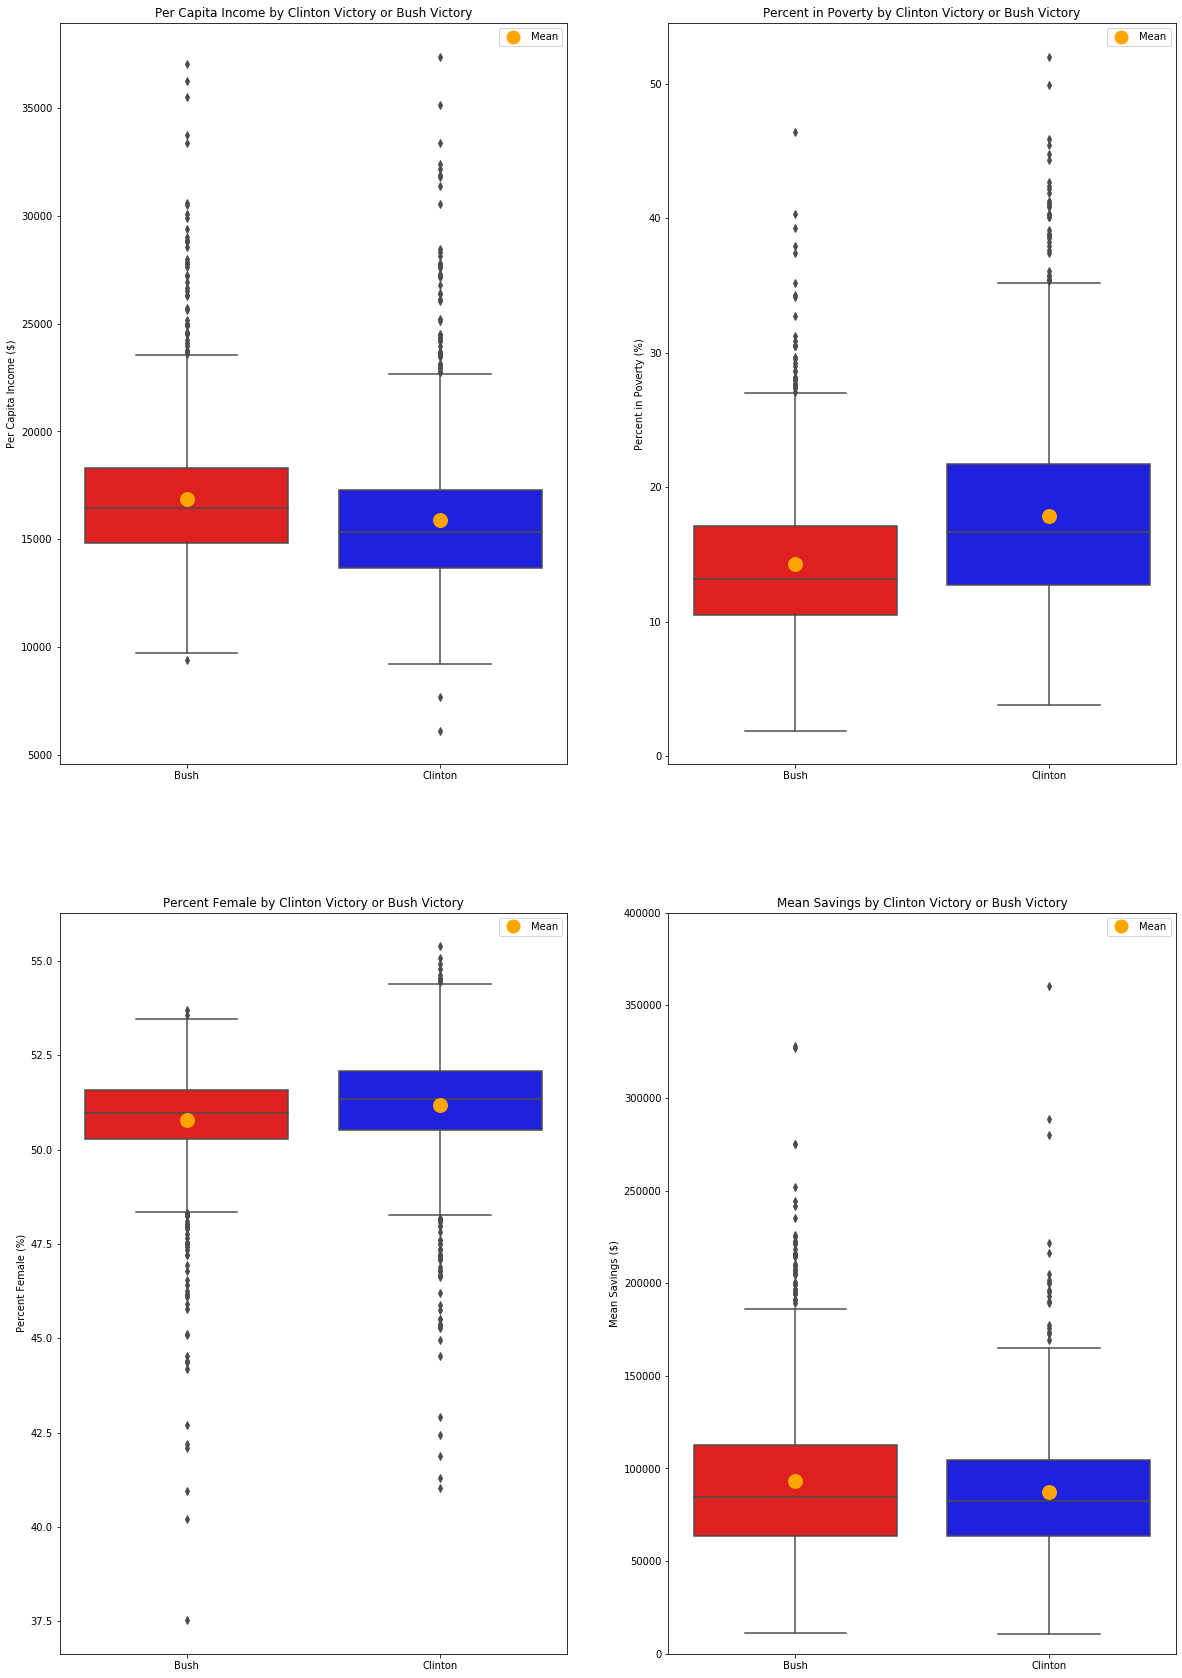

In [326]:
var_means = election_cp.groupby(['clinton_win']).mean()
var_means = var_means.reset_index()
plt.figure(figsize=[20,30])
plt.subplot(2,2,1)
sns.boxplot(x='clinton_win', y='per_capita_income', data=election_cp, palette=['red', 'blue']);
strplot = sns.stripplot(x='clinton_win', y='per_capita_income', data=var_means, color='orange', dodge=True,
             size=15, jitter=False);
plt.xticks(ticks=[False, True], labels=['Bush', 'Clinton'])
plt.xlabel('');
plt.ylabel('Per Capita Income ($)');
plt.title('Per Capita Income by Clinton Victory or Bush Victory');
yellow_dot =mlines.Line2D([0], [0], color='white', markerfacecolor='orange',
                          marker='o', markersize=15, label='Mean')
plt.legend(handles=[yellow_dot]);

plt.subplot(2,2,2)
sns.boxplot(x='clinton_win', y='percent_in_poverty', data=election_cp, palette=['red', 'blue']);
sns.stripplot(x='clinton_win', y='percent_in_poverty', data=var_means, color='orange', dodge=True,
              size=15, jitter=False);
plt.xticks(ticks=[False, True], labels=['Bush', 'Clinton'])
plt.xlabel('');
plt.ylabel('Percent in Poverty (%)');
plt.title('Percent in Poverty by Clinton Victory or Bush Victory');
plt.legend(handles=[yellow_dot]);

plt.subplot(2,2,3)
sns.boxplot(x='clinton_win', y='percent_female', data=election_cp, palette=['red', 'blue']);
sns.stripplot(x='clinton_win', y='percent_female', data=var_means, color='orange', dodge=True,
             size=15, jitter=False);
plt.xticks(ticks=[False, True], labels=['Bush', 'Clinton'])
plt.xlabel('');
plt.ylabel('Percent Female (%)');
plt.title('Percent Female by Clinton Victory or Bush Victory')
plt.legend(handles=[yellow_dot]);

plt.subplot(2,2,4)
sns.boxplot(x='clinton_win', y='mean_savings', data=election_cp, palette=['red', 'blue']);
plt.ylim([0,400000])
sns.stripplot(x='clinton_win', y='mean_savings', data=var_means, color='orange', dodge=True,
             size=15, jitter=False);
plt.xticks(ticks=[False, True], labels=['Bush', 'Clinton'])
plt.xlabel('');
plt.ylabel('Mean Savings ($)');
plt.title('Mean Savings by Clinton Victory or Bush Victory');
plt.legend(handles=[yellow_dot]);

plt.savefig('clustered_bp.png', format='png')

In [12]:
column_indices = list(range(2,11,1))
data_corr = election_cp.iloc[:,column_indices]
corr = data_corr.corr()

In [14]:
names = pd.Series(corr.columns.values)
names = names.str.replace("_", " ").str.title()

In [15]:
breaks = list(corr.columns.values)

## Question 5: Does multicollinearity exist between the demographic variables?
Multicollinearity does exist. For example, a moderately strong negative correlation exists between the "Per Capita Income" and "Percent in Poverty" variables.

Furthermore, this dataset might benefit from a PCA since there does seem to be several variables where there exists  a moderate amount of correlation. 

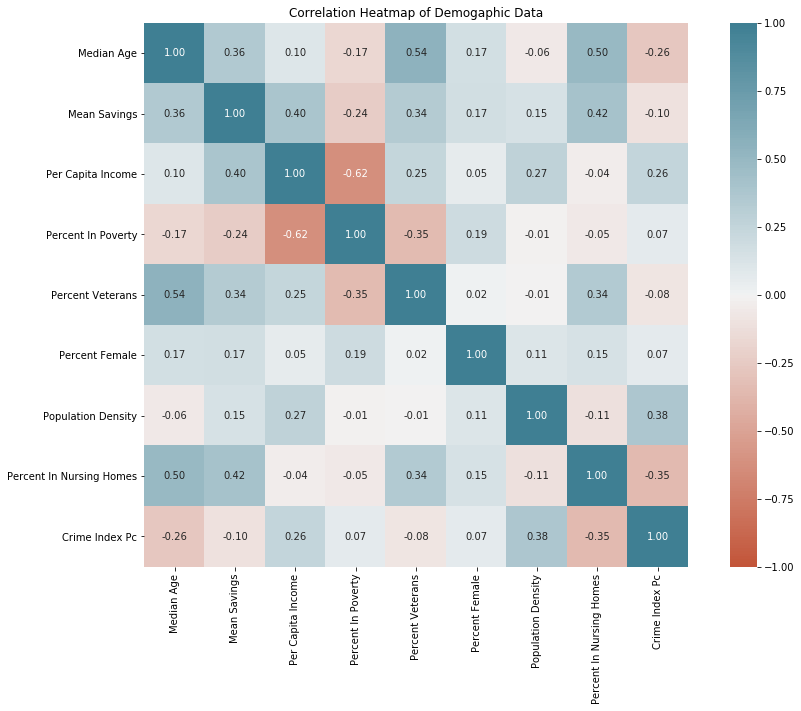

In [16]:
plt.figure(figsize=(15,10))
heatmap = sns.heatmap(data=corr, vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, n=200),
           square=True, annot=True, fmt=".2f");
plt.title('Correlation Heatmap of Demogaphic Data');
plt.xticks(ticks=list(np.arange(len(corr.columns.values)) + 0.5), labels=names);
plt.yticks(ticks=list(np.arange(len(corr.columns.values)) + 0.5), labels=names);
plt.savefig('correlation_heatmap.png', format='png')

In [17]:
clinton_won = election_cp[election_cp['clinton_win'] == True]
clinton_lost = election_cp[election_cp['clinton_win'] == False]
clinton_won = clinton_won.loc[:, ['median_age', 'mean_savings', 'per_capita_income', 'percent_in_poverty',
                                   'percent_veterans', 'percent_female', 'population_density',
                                   'percent_in_nursing_homes', 'crime_index_PC']]
clinton_lost = clinton_lost.loc[:, ['median_age', 'mean_savings', 'per_capita_income', 'percent_in_poverty',
                                   'percent_veterans', 'percent_female', 'population_density',
                                   'percent_in_nursing_homes', 'crime_index_PC']]

In [18]:
clinton_won_names = list(clinton_won.columns.values)

In [19]:
clinton_won_names = list(clinton_won.columns.values)
clinton_won_names = [name + "_clinton_won" for name in clinton_won_names]

clinton_lost_names = list(clinton_lost.columns.values)
clinton_lost_names = [name + "_clinton_lost" for name in clinton_lost_names]

names_cw = list(clinton_won.columns.values)
names_cl = list(clinton_lost.columns.values)

In [20]:
mapper_cw = {names_cw[i]:clinton_won_names[i] for i in range(len(names_cw))}
mapper_cl = {names_cl[i]:clinton_lost_names[i] for i in range(len(names_cl))}

In [21]:
election_cw = clinton_won.rename(columns=mapper_cw)
election_cl = clinton_lost.rename(columns=mapper_cl)
election_cl_samp = election_cl.sample(len(election_cw))

In [22]:
election_cw = election_cw.reset_index().drop(columns='index')
election_cl_samp = election_cl_samp.reset_index().drop(columns='index')

In [23]:
election_btwn_sample = election_cw.merge(election_cl_samp, how='inner', on=election_cl_samp.index)
election_btwn_sample = election_btwn_sample.drop(columns='key_0')

In [24]:
btwn_sample_corr = election_btwn_sample.corr()

## Question 6: Does the between sample independence assumption hold for the MANOVA?
From the correlation heatmap between the two different subpopulations, as seen below, we seen by looking at quadrants one and three that there seems to be little to no linear correlation between the two subpopulations. If the nonlinear correlation exists, it will appear in the residuals of the MANOVA and troubleshooting can be handled from there.

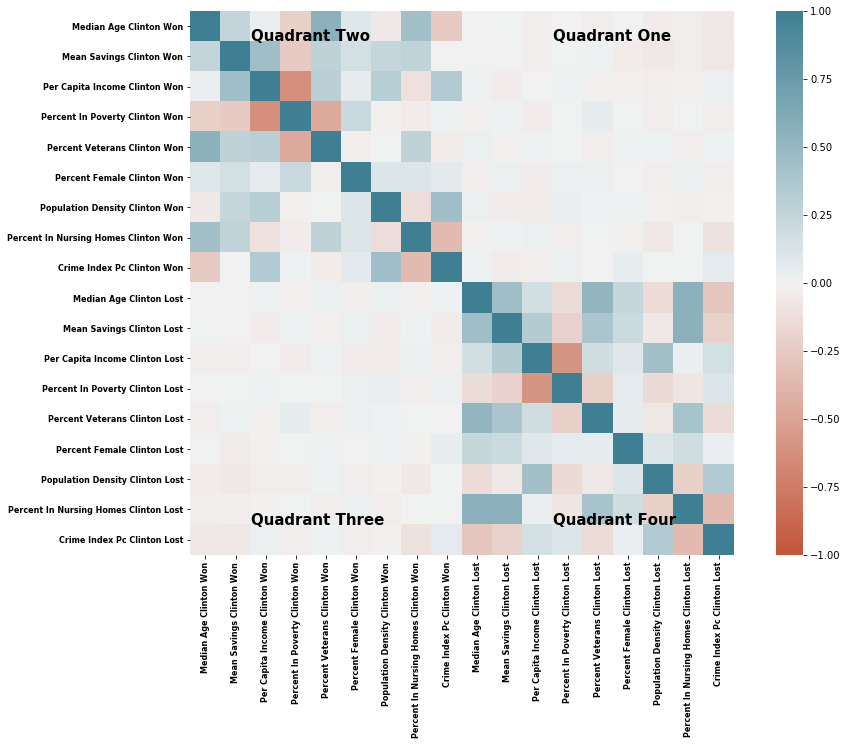

In [25]:
plt.figure(figsize=[15,10])
names = pd.Series(btwn_sample_corr.columns.values)
names = names.str.replace("_", " ").str.title()
heatmap = sns.heatmap(data=btwn_sample_corr, vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, n=200),
           square=True);
plt.xticks(ticks=list(np.arange(len(btwn_sample_corr.columns.values)) + 0.5), labels=names,
           size=8, weight='bold');
plt.yticks(ticks=list(np.arange(len(btwn_sample_corr.columns.values)) + 0.5), labels=names,
          size=8, weight='bold');
plt.text(12, 1, 'Quadrant One', weight='bold', size=15);
plt.text(2, 1, 'Quadrant Two', weight='bold', size=15);
plt.text(2, 17, 'Quadrant Three', weight='bold', size=15);
plt.text(12, 17, 'Quadrant Four', weight='bold', size=15);
plt.savefig('between_sample_heatmap.png', format='png');

In [26]:
man = MANOVA.from_formula('percent_female + per_capita_income + \
                          percent_in_poverty ~ clinton_win', data=election_cp)

In [27]:
print(man.mv_test())

                     Multivariate linear model
                                                                    
--------------------------------------------------------------------
       Intercept         Value   Num DF   Den DF    F Value   Pr > F
--------------------------------------------------------------------
          Wilks' lambda   0.0016 3.0000 2409.0000 497905.1999 0.0000
         Pillai's trace   0.9984 3.0000 2409.0000 497905.1999 0.0000
 Hotelling-Lawley trace 620.0563 3.0000 2409.0000 497905.1999 0.0000
    Roy's greatest root 620.0563 3.0000 2409.0000 497905.1999 0.0000
--------------------------------------------------------------------
                                                                    
---------------------------------------------------------------------
        clinton_win        Value   Num DF    Den DF   F Value  Pr > F
---------------------------------------------------------------------
            Wilks' lambda  0.9183  3.0000  2409.0000 

In [28]:
pca = PCA(data=data_corr, standardize=True)

In [29]:
pca_eigs = pca.eigenvals
numerator = np.cumsum(pca.eigenvals)
denominator = sum(pca.eigenvals)

In [30]:
cumulative_var = pd.Series(numerator / denominator)
cumulative_var = cumulative_var.reset_index(name='percent variance explained')
cumulative_var['index'] = cumulative_var.index + 1

In [31]:
old_names = list(cumulative_var.columns.values)
new_names = ['component number/number of components', 'variance explained']
mapper = {old_names[i]:new_names[i] for i in range(0,len(old_names),1)}

In [32]:
cumulative_var = cumulative_var.rename(columns=mapper)

In [33]:
pca_eigs = pd.Series(pca_eigs)

In [34]:
cumulative_var = pd.concat([cumulative_var,pca_eigs], axis=1)

## Question 7: How many principal components should be retained if it is decided to use the PCs to be the input of the models in the future?
From the variance explained plot and the scree plot, there should be 4 principal components retained.

75% of the variance is explained by only using the first four principal components - this is the vast majority of the variance.

The elbow in the scree plot happens at component four.

Both of these facts combined indicate that four principal components should be enough if a full PCA is to be performed.

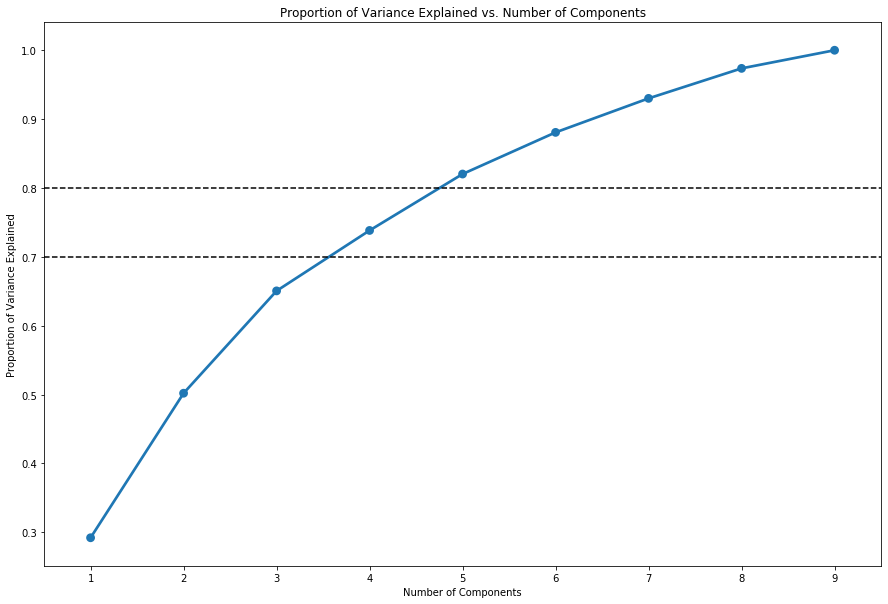

In [35]:
plt.figure(figsize=[15,10])
sns.pointplot(data=cumulative_var, x='component number/number of components', y='variance explained');
plt.axhline([0.7], linestyle='--', color='black');
plt.axhline([0.8], linestyle='--', color='black');
plt.xlabel('Number of Components');
plt.ylabel('Proportion of Variance Explained');
plt.title('Proportion of Variance Explained vs. Number of Components');
plt.savefig('cum_var.png', format='png')

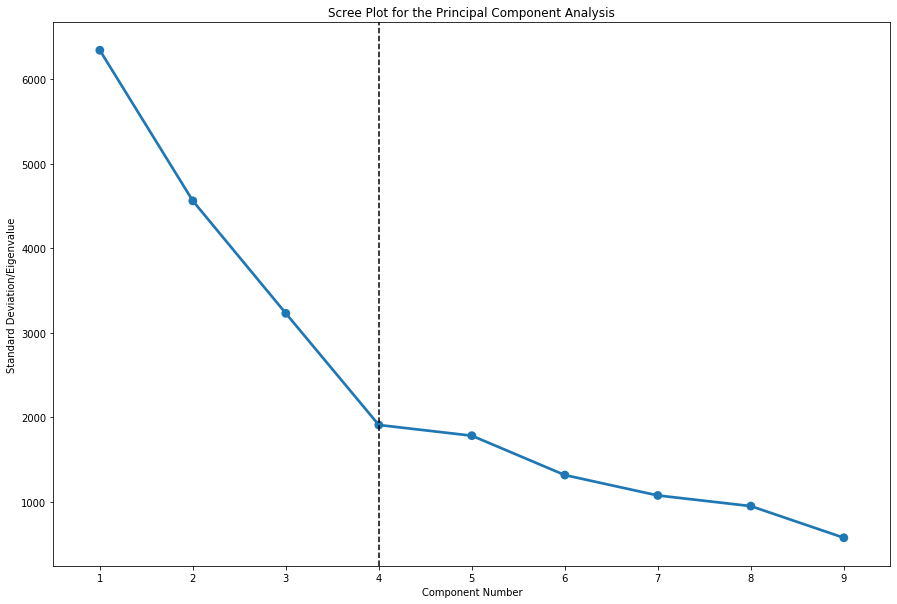

In [36]:
plt.figure(figsize=[15,10])
sns.pointplot(data=cumulative_var, x='component number/number of components', y='eigenvals');
plt.axvline(3, linestyle='--', color='black')
plt.xlabel('Component Number');
plt.ylabel('Standard Deviation/Eigenvalue');
plt.title('Scree Plot for the Principal Component Analysis');
plt.savefig('scree_plt.png', format='png')

## Question 8: What kind of class separation exists between counties that Clinton lost or won?

From a glimpse at the scatter plots below from two of the demographic variables we can see that there is no clear decision boundary. Therefore, we can conclude that discriminants, such as LDA and QDA, *will not* make good classifiers for this dataset.

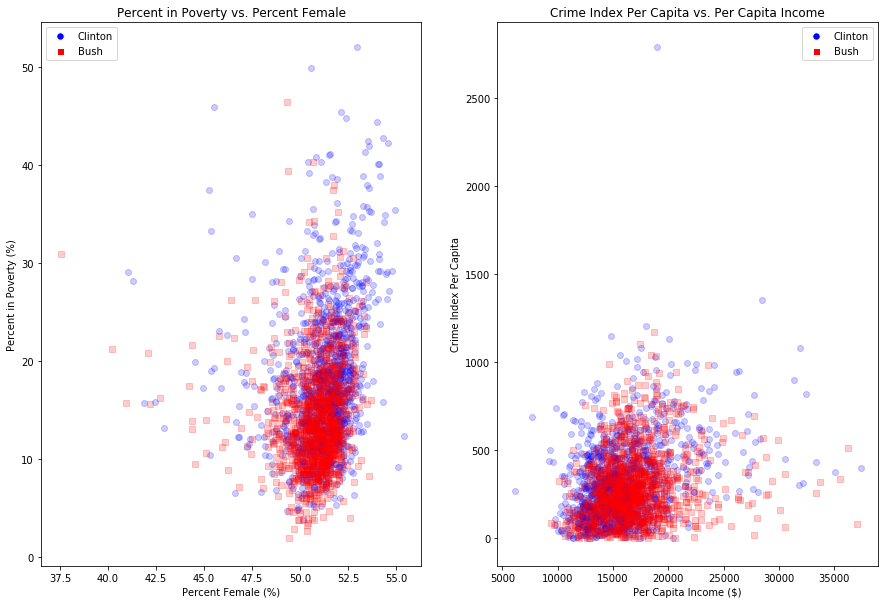

In [324]:
cat_markers = [[True, 'o','blue'],
               [False, 's','red']]
plt.figure(figsize=[15,10])
plt.subplot(1,2,1)
for cat, marker, color in cat_markers:
    election_cat = election_cp[election_cp['clinton_win'] == cat]
    plt.scatter(data=election_cat, x='percent_female', y='percent_in_poverty', marker=marker,
                alpha=1/5, c=color);
clinton_dot = mlines.Line2D([0], [0], color='white', markerfacecolor='blue',
                          marker='.', markersize=15, label='Clinton')
bush_dot = mlines.Line2D([0], [0], color='white', markerfacecolor='red',
                          marker='s', markersize=7, label='Bush')
plt.xlabel('Percent Female (%)');
plt.ylabel('Percent in Poverty (%)');
plt.title('Percent in Poverty vs. Percent Female');
plt.legend(handles=[clinton_dot, bush_dot]);

plt.subplot(1,2,2)
for cat, marker, color in cat_markers:
    election_cat = election_cp[election_cp['clinton_win'] == cat]
    plt.scatter(data=election_cat, x='per_capita_income', y='crime_index_PC', marker=marker,
                alpha=1/5, c=color);
plt.xlabel('Per Capita Income ($)');
plt.ylabel('Crime Index Per Capita')
plt.title('Crime Index Per Capita vs. Per Capita Income');
plt.legend(['Clinton', 'Bush']);
plt.legend(handles=[clinton_dot, bush_dot]);
plt.savefig('scatter.png', format='png')